In [ ]:
# To study the interdependencies between DED and insomnia and uncover patterns that are common for certain groups

In [161]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

#Import some packages for visualization
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [162]:
# !pip install kmodes

In [163]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from kmodes.kprototypes import KPrototypes
from sklearn.model_selection import train_test_split
import xgboost as xgb

In [164]:
# path to the dataset
file_path = "Dry_Eye_Dataset.csv"

# Load the latest version of the file
df0 = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "dakshnagra/dry-eye-disease",
  file_path,
  # Provide any additional arguments like 
  # sql_query or pandas_kwargs. See the 
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

/var/folders/h4/8_8xkn4579zbrdb79s7zrtl00000gp/T/ipykernel_29205/3521891120.py:5: DeprecationWarning: load_dataset is deprecated and will be removed in future version.
  df0 = kagglehub.load_dataset(


In [165]:
df.columns

Index(['gender', 'age', 'sleep_duration', 'sleep_quality', 'stress_level',
       'heart_rate', 'daily_steps', 'physical_activity', 'height', 'weight',
       'sleep_disorder', 'wake_up_during_night', 'feel_sleepy_during_day',
       'caffeine_consumption', 'alcohol_consumption', 'smoking',
       'medical_issue', 'ongoing_medication', 'smart_device_before_bed',
       'average_screen_time', 'blue_light_filter', 'discomfort_eye_strain',
       'redness_in_eye', 'eye_irritation', 'dry_eye_disease', 'bp_category',
       'bmi', 'insomnia', 'ded_insomnia_group', 'cluster'],
      dtype='object')

In [166]:
df = df0.copy()

#Make everything lower case, and replace space with '_'
df.columns = [col.lower().replace(" ", "_").replace("-", "_").replace("itchiness/irritation_in_eye", 'eye_irritation') for col in df.columns]

# Split the blood_pressure column into two new columns
df[['systolic', 'diastolic']] = df['blood_pressure'].str.split('/', expand=True)

# Define the Blood Pressure Category
def categorize_bp(row):
    if 110 <= int(row['systolic']) <= 120 and 70 <= int(row['diastolic']) <= 80:
        return 'normal'
    elif int(row['systolic']) > 120 or int(row['diastolic']) > 80:
        return 'high'
    else:
        return 'low'
# New BP category column
df['bp_category'] = df.apply(categorize_bp, axis=1)

In [167]:
omit_cols = ['blood_pressure',
              'systolic',
              'diastolic']
df = df.drop(columns=omit_cols)

In [168]:
def bmi(row):

    return row['weight']/(row['height']/100.0)**2

df['bmi'] = df.apply(bmi, axis=1)

In [169]:
df.columns

Index(['gender', 'age', 'sleep_duration', 'sleep_quality', 'stress_level',
       'heart_rate', 'daily_steps', 'physical_activity', 'height', 'weight',
       'sleep_disorder', 'wake_up_during_night', 'feel_sleepy_during_day',
       'caffeine_consumption', 'alcohol_consumption', 'smoking',
       'medical_issue', 'ongoing_medication', 'smart_device_before_bed',
       'average_screen_time', 'blue_light_filter', 'discomfort_eye_strain',
       'redness_in_eye', 'eye_irritation', 'dry_eye_disease', 'bp_category',
       'bmi'],
      dtype='object')

In [170]:
#Creating the target for insomnia from: 
#Sleep disorder, sleep quality, sleep duration, 'Feel sleepy during day', and 'Wake up during night'

In [171]:
def define_insomnia(row):
    criteria_met = 0
    
    # Check if each criterion is met
    if row['sleep_disorder'] == 'Y':  # Only consider those with sleep disorder
        criteria_met+=1
    if row['sleep_duration'] < 6:
            criteria_met += 1
    if row['sleep_quality'] <= 2:
        criteria_met += 1
    if row['feel_sleepy_during_day'] == 'Y':
        criteria_met += 1
    if row['wake_up_during_night'] == 'Y':
        criteria_met += 1
    
    # Assign insomnia as 1 if 2 or more criteria are met
    if criteria_met >= 3:
        return 1
    return 0  # Insomnia = 0 if fewer than 2 criteria are met

# Apply the function to create a new column 'Insomnia'
df['insomnia'] = df.apply(define_insomnia, axis=1)

In [172]:
'''
This shows why including sleep disorder as a general condition instead as a first filter is a better approach, since sleep disorder can
include conditions other than insomnia. For example, for this person, although sleep disorder is Y, the other conditions for insomnia
are not satisfied.
'''

print(df.iloc[1999])

gender                             M
age                               41
sleep_duration                   8.2
sleep_quality                      4
stress_level                       2
heart_rate                        85
daily_steps                    11000
physical_activity                 48
height                           179
weight                            61
sleep_disorder                     Y
wake_up_during_night               N
feel_sleepy_during_day             N
caffeine_consumption               N
alcohol_consumption                N
smoking                            N
medical_issue                      N
ongoing_medication                 N
smart_device_before_bed            Y
average_screen_time              2.2
blue_light_filter                  Y
discomfort_eye_strain              N
redness_in_eye                     N
eye_irritation                     Y
dry_eye_disease                    Y
bp_category                     high
bmi                        19.038107
i

In [173]:
df['insomnia'].value_counts()

insomnia
0    12104
1     7896
Name: count, dtype: int64

In [174]:
df.columns

Index(['gender', 'age', 'sleep_duration', 'sleep_quality', 'stress_level',
       'heart_rate', 'daily_steps', 'physical_activity', 'height', 'weight',
       'sleep_disorder', 'wake_up_during_night', 'feel_sleepy_during_day',
       'caffeine_consumption', 'alcohol_consumption', 'smoking',
       'medical_issue', 'ongoing_medication', 'smart_device_before_bed',
       'average_screen_time', 'blue_light_filter', 'discomfort_eye_strain',
       'redness_in_eye', 'eye_irritation', 'dry_eye_disease', 'bp_category',
       'bmi', 'insomnia'],
      dtype='object')

In [177]:
def classify_group(row):
    if row['dry_eye_disease'] == 'Y' and row['insomnia'] == 1:
        return 'both'  # Group A
    elif row['dry_eye_disease'] == 'Y' and row['insomnia'] == 0:
        return 'ded'  # Group B
    elif row['dry_eye_disease'] == 'N' and row['insomnia'] == 1:
        return 'insomnia'  # Group C
    else:
        return 'none'  # Group D

df['ded_insomnia_group'] = df.apply(classify_group, axis=1)

In [178]:
df.ded_insomnia_group.value_counts()

ded_insomnia_group
ded         7843
both        5194
none        4261
insomnia    2702
Name: count, dtype: int64

In [149]:
drop_features = ['ded_insomnia_group', 'dry_eye_disease', 'insomnia', 'sleep_disorder']

# Keep key sleep features, drop derived labels
X_cluster = df.drop(columns=drop_features)

In [150]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   gender                   20000 non-null  object 
 1   age                      20000 non-null  int64  
 2   sleep_duration           20000 non-null  float64
 3   sleep_quality            20000 non-null  int64  
 4   stress_level             20000 non-null  int64  
 5   heart_rate               20000 non-null  int64  
 6   daily_steps              20000 non-null  int64  
 7   physical_activity        20000 non-null  int64  
 8   height                   20000 non-null  int64  
 9   weight                   20000 non-null  int64  
 10  sleep_disorder           20000 non-null  object 
 11  wake_up_during_night     20000 non-null  object 
 12  feel_sleepy_during_day   20000 non-null  object 
 13  caffeine_consumption     20000 non-null  object 
 14  alcohol_consumption   

In [151]:
cols_to_drop = ['dry_eye_disease', 'insomnia', 'ded_insomnia_group', 'sleep_disorder', 'height', 'weight']

X_cluster = df.drop(columns=cols_to_drop)

In [152]:
X_cluster.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   gender                   20000 non-null  object 
 1   age                      20000 non-null  int64  
 2   sleep_duration           20000 non-null  float64
 3   sleep_quality            20000 non-null  int64  
 4   stress_level             20000 non-null  int64  
 5   heart_rate               20000 non-null  int64  
 6   daily_steps              20000 non-null  int64  
 7   physical_activity        20000 non-null  int64  
 8   wake_up_during_night     20000 non-null  object 
 9   feel_sleepy_during_day   20000 non-null  object 
 10  caffeine_consumption     20000 non-null  object 
 11  alcohol_consumption      20000 non-null  object 
 12  smoking                  20000 non-null  object 
 13  medical_issue            20000 non-null  object 
 14  ongoing_medication    

In [153]:
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()  # Categorical columns
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()  # Numerical columns

In [154]:
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le #storing encoders for later interpretation

scaler = StandardScaler()

df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

#Converting df to numpy array

X = df.to_numpy()

In [155]:
# Choose the number of clusters (k)
k = 2  # You can try different values
kproto = KPrototypes(n_clusters=k, init='Huang', random_state=42)
clusters = kproto.fit_predict(X, categorical=list(range(len(categorical_cols))))  # Indexes of categorical columns

# Add cluster labels to dataframe
df['cluster'] = clusters

In [156]:
from sklearn.metrics import silhouette_score

silhouette_avg = silhouette_score(df[numerical_cols], clusters)
print(f"Silhouette Score: {silhouette_avg:.4f}")

Silhouette Score: 0.1045


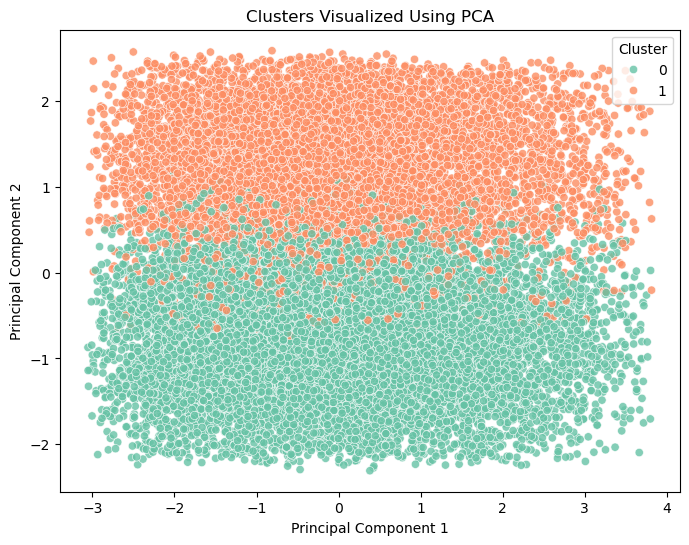

In [157]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# Reduce dimensions to 2D for visualization
pca = PCA(n_components=2)
pca_components = pca.fit_transform(df[numerical_cols])  # PCA only works with numerical data

# Create DataFrame for visualization
df_pca = pd.DataFrame(pca_components, columns=['PC1', 'PC2'])
df_pca['cluster'] = df['cluster'].values  # Ensure cluster labels are properly assigned

# Scatter plot with correct DataFrame
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='cluster', palette='Set2', alpha=0.8)
plt.title("Clusters Visualized Using PCA")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.show()

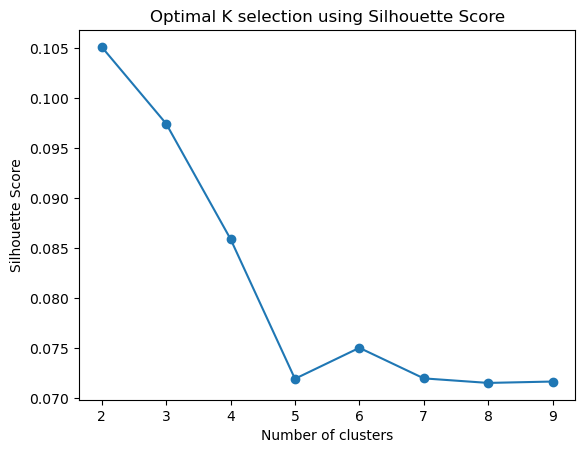

In [158]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

sil_scores = []
K = range(2, 10)  # Testing different k values

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(df[numerical_cols])  # Ensure using only numerical features
    sil_scores.append(silhouette_score(df[numerical_cols], labels))

# Plot the silhouette scores
plt.plot(K, sil_scores, marker='o')
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette Score")
plt.title("Optimal K selection using Silhouette Score")
plt.show()

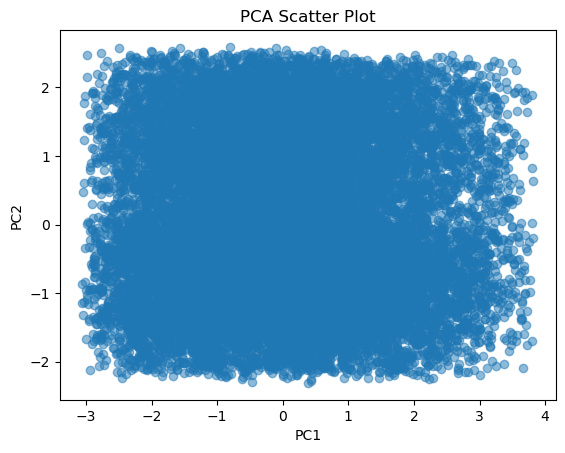

In [159]:
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

pca = PCA(n_components=2)  # Reduce to 2D for visualization
df_pca = pca.fit_transform(df[numerical_cols])  # Use only numerical columns

plt.scatter(df_pca[:, 0], df_pca[:, 1], alpha=0.5)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA Scatter Plot')
plt.show()

In [123]:
# Encode categorical variables
label_encoders = {}
for col in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le  # Store encoders for later interpretation

# Define feature sets
features_ded = df.drop(columns=["dry_eye_disease", "insomnia", 'ded_insomnia_group'])  # Drop insomnia to predict DED
features_insomnia = df.drop(columns=["insomnia"] + ["sleep_duration", "sleep_quality", "sleep_disorder", "wake_up_during_night", "feel_sleepy_during_day"] + ['ded_insomnia_group'])  # Drop defining features
features_group = df.drop(columns=["ded_insomnia_group"])  # Use all features

# Define targets
target_ded = df["dry_eye_disease"]
target_insomnia = df["insomnia"]
target_group = df["ded_insomnia_group"]

# Split data
X_train_ded, X_test_ded, y_train_ded, y_test_ded = train_test_split(features_ded, target_ded, test_size=0.2, random_state=42)
X_train_insomnia, X_test_insomnia, y_train_insomnia, y_test_insomnia = train_test_split(features_insomnia, target_insomnia, test_size=0.2, random_state=42)
X_train_group, X_test_group, y_train_group, y_test_group = train_test_split(features_group, target_group, test_size=0.2, random_state=42)

In [124]:
features_ded.columns

Index(['gender', 'age', 'sleep_duration', 'sleep_quality', 'stress_level',
       'heart_rate', 'daily_steps', 'physical_activity', 'height', 'weight',
       'sleep_disorder', 'wake_up_during_night', 'feel_sleepy_during_day',
       'caffeine_consumption', 'alcohol_consumption', 'smoking',
       'medical_issue', 'ongoing_medication', 'smart_device_before_bed',
       'average_screen_time', 'blue_light_filter', 'discomfort_eye_strain',
       'redness_in_eye', 'eye_irritation', 'bp_category', 'bmi', 'cluster'],
      dtype='object')

In [132]:
print(df["dry_eye_disease"].unique())  # Should be [0,1]
print(df["insomnia"].unique())  # Should be [0,1]
print(df["ded_insomnia_group"].unique())  # Should be [0,1]
df["insomnia"] = df["insomnia"].astype(int)

[1 0]
[0 1]
[0]


In [130]:
print(df["dry_eye_disease"].unique())  # Should be [0,1]
print(df["insomnia"].unique())  # Should be [0,1]

[1 0]
[0 1]


In [133]:
# Train XGBoost models
def train_xgboost(X_train, y_train, X_test, y_test):
    model = xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss")
    model.fit(X_train, y_train)
    return model

model_ded = train_xgboost(X_train_ded, y_train_ded, X_test_ded, y_test_ded)
model_insomnia = train_xgboost(X_train_insomnia, y_train_insomnia, X_test_insomnia, y_test_insomnia)
#model_group = train_xgboost(X_train_group, y_train_group, X_test_group, y_test_group)

# Plot feature importance
def plot_feature_importance(model, features, title):
    importance = model.feature_importances_
    sorted_idx = np.argsort(importance)[::-1]
    plt.figure(figsize=(10, 6))
    plt.barh(np.array(features.columns)[sorted_idx], importance[sorted_idx], color="steelblue")
    plt.xlabel("Feature Importance")
    plt.ylabel("Features")
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.show()

plot_feature_importance(model_ded, X_train_ded, "Feature Importance for DED Prediction")
plot_feature_importance(model_insomnia, X_train_insomnia, "Feature Importance for Insomnia Prediction")
#plot_feature_importance(model_group, X_train_group, "Feature Importance for DED & Insomnia Group Prediction")

/Users/anweshabasu/miniconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:51:51] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1738880277541/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1], got [-0.8076796   1.23811472]